In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial
from serial.tools import list_ports
from datetime import datetime
from scipy.fft import fft, fftfreq

In [3]:
ports = list_ports.comports()
devices = [info.device for info in ports]
devices

['COM3', 'COM5', 'COM4']

In [4]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20230912_131931'

Serial<id=0x21243d260e0, open=True>(port='COM3', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=1, xonxoff=False, rtscts=False, dsrdtr=False)
 False
 False
 False
receiving data now
1071 0.91602 -0.05762 0.06519 True
1994 0.87866 -0.10986 0.09131 True
2913 0.90234 -0.12915 0.09766 True
3832 0.95142 -0.07861 0.08252 True
4751 1.07544 -0.02344 0.11963 True
5670 1.14746 -0.03516 0.22925 True
6589 1.08691 -0.05444 0.35986 True
7508 1.08691 -0.05444 0.35986 True
8427 1.03931 -0.03027 0.46655 True
9353 1.06592 0.00195 0.49902 True
10272 1.18823 0.05811 0.48096 True
11191 1.29761 0.17773 0.44873 True
12110 1.22632 0.33545 0.46460 True
13029 1.04248 0.34424 0.42407 True
13948 1.05786 0.43042 0.27344 True
14867 1.09912 0.58325 0.12109 True
15786 0.97729 0.55420 0.05713 True
16708 0.88843 0.47070 0.06543 True
17626 0.86182 0.37866 -0.01001 True
18545 0.71924 0.35864 -0.09888 True
19466 0.71924 0.35864 -0.09888 True
20385 0.61084 0.30835 -0.19116 True
21304 0.65894 0.31274 -0.17651 

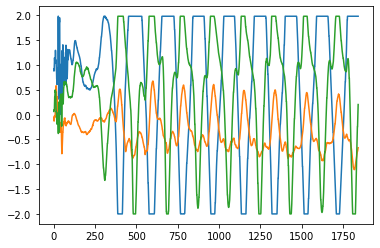

In [7]:
break_flag = False
is_data_available = False
t_list = []
accX_list = []
accY_list = []
accZ_list = []

save_data = True
is_started = False
DIR = "data"

if not os.path.exists(DIR):
    os.makedirs("data")


with serial.Serial("COM3", 115200, timeout=1) as ser:
    print(ser)
    while True:
        try:
            line = ser.readline()   # read a '\n' terminated line
            text_data = line.decode().split("\n")[0]
            print(text_data, is_started)
            
            
            if "start" in text_data:
                print("receiving data now")
                is_started = True
                t_list = []
                accX_list = []
                accY_list = []
                accZ_list = []
                now_str = datetime.now().strftime("%Y%m%d_%H%M%S")
                
                
            elif is_started and ("end" in text_data):
                is_started = False
                plt.plot(t_list, accX_list, label="Z")
                plt.plot(t_list, accY_list, label="Y")
                plt.plot(t_list, accZ_list, label="Z")
                df = pd.DataFrame()
                df["time(ms)"]=t_list
                df["accX(G)"]=accX_list
                df["accY(G)"]=accY_list
                df["accZ(G)"]=accZ_list
                df.to_csv(os.path.join(DIR, f"{now_str}.csv"), index=False)
                break_flag = True
            
            elif is_started and (text_data != ""):
                t, accX, accY, accZ = text_data.split(" ")
                t_list.append(int(t)/1000)
                accX_list.append(float(accX))
                accY_list.append(float(accY))
                accZ_list.append(float(accZ))
                
            
        except ValueError:
            pass

        except KeyboardInterrupt:
            # print(t_list)
            print("Keyboard Interrupt")
            ser.close()
            break_flag = True
        
        if break_flag: break

In [31]:
df = pd.read_csv("imu_data/20230529_165023_test.csv")
df

,time(ms),accX(G),accY(G),accZ(G)
0,435,-0.76709,-0.42578,0.51733
1,725,-0.76709,-0.42578,0.51733
2,1007,-0.76709,-0.42578,0.51733
3,1290,-0.76709,-0.42578,0.51733
4,1572,-0.76709,-0.42578,0.51733
...,...,...,...,...
3995,1130058,-1.57690,-0.50391,0.61499
3996,1130340,-1.57690,-0.50391,0.61499
3997,1130631,-1.57690,-0.50391,0.61499
3998,1130914,-1.57690,-0.50391,0.61499


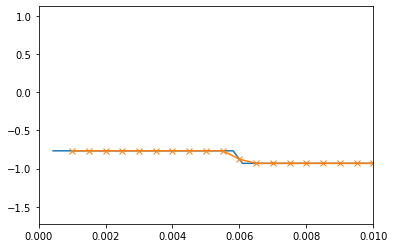

In [66]:
t = df["time(ms)"]/1E6
accX = df["accX(G)"]

dt = 0.5E-3

t_vals = np.arange(2*dt, 1+2*dt, dt)

accX_interp = np.interp(t_vals, t, accX)

plt.plot(t, accX)
plt.plot(t_vals, accX_interp, marker="x")
plt.xlim(0, 0.01)

F = np.fft.fft(accX_interp) # 変換結果
freq = np.fft.fftfreq(t_vals.shape[0], d=dt) # 周波数


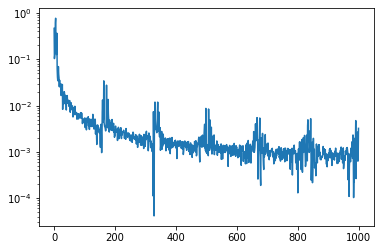

In [67]:

n = t_vals.shape[0]

freq = fftfreq(n, dt)[:n//2]
amp = np.abs(fft(accX_interp)[:n//2])/(n/ 2)



plt.plot(freq, amp)
plt.yscale("log")

In [68]:
n

2000